# Data Loading

In [ ]:
# Install the Google Drive package
install.packages("googledrive")
library(googledrive)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
# # De-auth if necessary
# drive_deauth()

In [ ]:
# Authenticate
drive_auth()

In [ ]:
# Check folder contents
drive_ls("Datasets/PBData")

In [ ]:
# Download the data
argos_dl <- drive_download(
    file = drive_get("Datasets/PBData/PB_Argos.csv"),
    path = "PB_Argos.csv",
    overwrite = TRUE
)

✔ The input `path` resolved to exactly 1 file.

File downloaded:

• PB_Argos.csv <id: 1OLUaLtsRfplFjGgWLLUAwTYK-C5U5tR1>

Saved locally as:

• PB_Argos.csv



In [ ]:
# Read in the data
data_pb_argos <- read.csv(argos_dl$local_path, stringsAsFactors = FALSE)
head(data_pb_argos)

,DateTime,QualClass,Lat,Lon
,<chr>,<chr>,<dbl>,<dbl>
1,2009.04.20 17:01:39,B,70.365,-131.837
2,2009.04.20 17:23:00,A,70.953,-131.381
3,2009.04.20 18:12:15,A,70.957,-131.365
4,2009.04.20 20:43:17,A,70.909,-131.418
5,2009.04.21 17:11:29,B,71.331,-131.607
6,2009.04.21 17:47:36,B,71.225,-132.099


In [ ]:
# Download the data
gps_dl <- drive_download(
    file = drive_get("Datasets/PBData/PB_GPS.csv"),
    path = "PB_GPS.csv",
    overwrite = TRUE
)

✔ The input `path` resolved to exactly 1 file.

File downloaded:

• PB_GPS.csv <id: 1e0p4wV7SDFv3vqm7sD6JG5dObN-9Lhon>

Saved locally as:

• PB_GPS.csv



In [ ]:
# Read in the data
data_pb_gps <- read.csv(gps_dl$local_path, stringsAsFactors = FALSE)
head(data_pb_gps)

,DateTime,Lat,Lon
,<chr>,<dbl>,<dbl>
1,2009.04.20 17:00:37,70.95645,-131.3861
2,2009.04.21 17:00:35,71.08914,-131.5248
3,2009.04.22 17:00:37,71.10673,-131.6351
4,2009.04.23 17:00:37,71.08545,-131.6075
5,2009.04.24 17:00:37,71.22733,-131.7066
6,2009.04.25 17:01:07,71.23823,-131.8137


# Data Plotting

In [ ]:
# Set default plot size for the notebook
options(repr.plot.width = 14, repr.plot.height = 8)

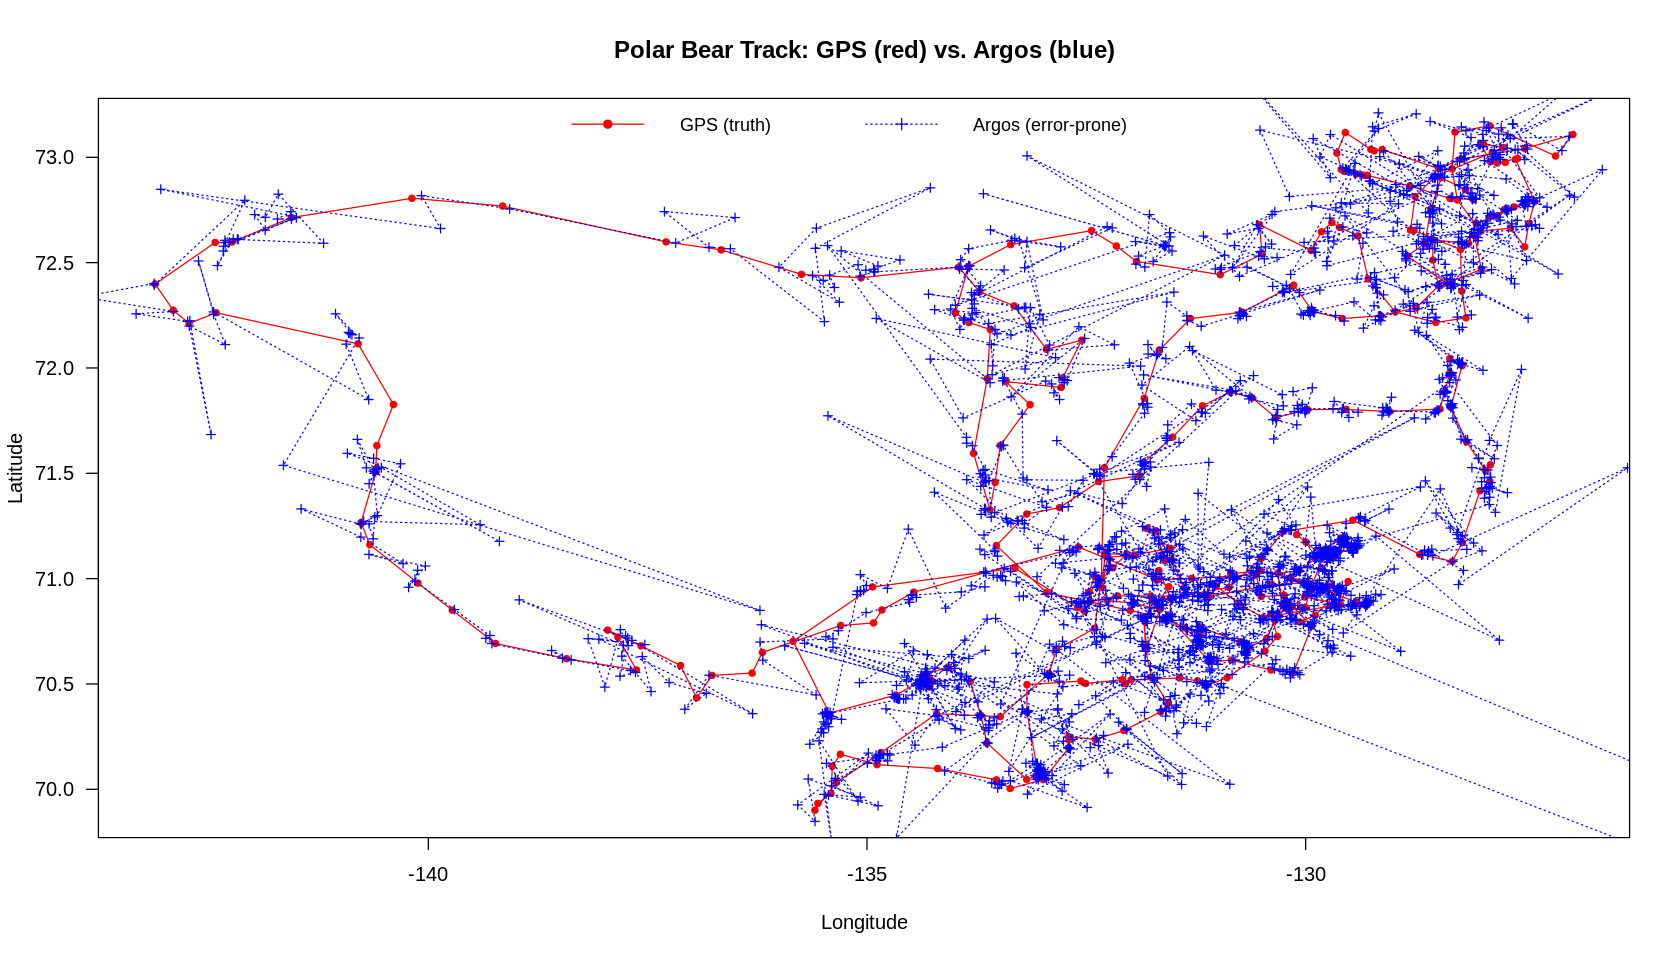

In [ ]:
# Plot Argos vs. GPS raw locations
plot(
    data_pb_gps$Lon,
    data_pb_gps$Lat,
    type = "o",
    pch = 19,
    cex = 0.7,
    col = "red",
    las = 1,
    xlab = "Longitude",
    ylab = "Latitude",
    main = "Polar Bear Track: GPS (red) vs. Argos (blue)"
)

points(
    data_pb_argos$Lon,
    data_pb_argos$Lat,
    type = "o",
    pch = 3,
    cex = 0.7,
    col = "blue",
    lty = 3
)

legend(
    "top",
    legend = c("GPS (truth)", "Argos (error‐prone)"),
    pch = c(19, 3),
    col = c("red", "blue"),
    lty = c(1, 3),
    bty = "n",
    cex = 0.9,
    horiz = TRUE,
    text.width = 2
)

# Data Preparation

In [ ]:
# Convert the Argos DateTime to POSIXlt
data_pb_argos$Time <- as.POSIXlt(
    data_pb_argos$DateTime,
    format = "%Y.%m.%d %H:%M:%S",
    tz = "UTC"
)
data_pb_argos$Date <- as.Date(data_pb_argos$Time)

In [ ]:
# Build the sequence of "state" times (every day at 17:00)
all_days <- seq(
  from = data_pb_argos$Date[1],
  to = data_pb_argos$Date[length(data_pb_argos$Time)] + 1,
  by = 1
)
all_days <- as.POSIXlt(paste(all_days, "17:00"), tz = "UTC")

In [ ]:
# For each Argos obs, find:
#    - idx: which all_days interval it is leading into
#    - ji: the fraction of the 24h interval elapsed
data_pb_argos$idx <- findInterval(data_pb_argos$Time, all_days) + 1

data_pb_argos$ji <- as.numeric(
  24 - difftime(
    all_days[data_pb_argos$idx],
    data_pb_argos$Time,
    units = "hours"
  )
) / 24

In [ ]:
# Build the Argos‐error matrix
ArgosC <- matrix(
    nrow = 6,
    ncol = 4,
    dimnames = list(
        c("B", "A", "0", "1", "2", "3"),
        c("TLon", "NuLon", "TLat", "NuLat")
    )
)

ArgosC[,"TLon"] <- c(
    0.037842190,
    0.004565261,
    0.019461776,
    0.008117727,
    0.002807138,
    0.002608584
)

ArgosC[,"TLat"] <- c(
    0.027369282,
    0.004594551,
    0.014462340,
    0.004142703,
    0.002344425,
    0.001098409
)

ArgosC[,"NuLon"] <- c(
    3.00001,
    3.00001,
    3.00001,
    3.00001,
    3.00001,
    3.070609
)

ArgosC[,"NuLat"] <- c(
    3.00001,
    3.00001,
    3.00001,
    3.896554,
    6.314726,
    3.00001
)

In [ ]:
# Tack on all four params in one go
data_pb_argos$ac <- ArgosC[
    as.character(data_pb_argos$QualClass),
]

# Inspect
head(data_pb_argos)

,DateTime,QualClass,Lat,Lon,Time,Date,idx,ji,ac
,<chr>,<chr>,<dbl>,<dbl>,<dttm>,<date>,<dbl>,<dbl>,"<dbl[,4]>"
1,2009.04.20 17:01:39,B,70.365,-131.837,2009-04-20 17:01:39,2009-04-20,2,0.001145833,"0.037842190, 3.00001, 0.027369282, 3.00001"
2,2009.04.20 17:23:00,A,70.953,-131.381,2009-04-20 17:23:00,2009-04-20,2,0.015972222,"0.004565261, 3.00001, 0.004594551, 3.00001"
3,2009.04.20 18:12:15,A,70.957,-131.365,2009-04-20 18:12:15,2009-04-20,2,0.050173611,"0.004565261, 3.00001, 0.004594551, 3.00001"
4,2009.04.20 20:43:17,A,70.909,-131.418,2009-04-20 20:43:17,2009-04-20,2,0.155057870,"0.004565261, 3.00001, 0.004594551, 3.00001"
5,2009.04.21 17:11:29,B,71.331,-131.607,2009-04-21 17:11:29,2009-04-21,3,0.007974537,"0.037842190, 3.00001, 0.027369282, 3.00001"
6,2009.04.21 17:47:36,B,71.225,-132.099,2009-04-21 17:47:36,2009-04-21,3,0.033055556,"0.037842190, 3.00001, 0.027369282, 3.00001"


# TMB Model

In [ ]:
# Install TMB package if not already installed
if (!require("TMB")) {
  install.packages("TMB")
}

library(TMB)

Loading required package: TMB

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘TMB’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘RcppEigen’




In [ ]:
# Create the C++ file
cat('
#include <TMB.hpp>
using namespace density;

template<class Type>
Type objective_function<Type>::operator() ()
{
  // Specify the input data
  DATA_ARRAY(y);     // Longitude and latitude of locations
  DATA_VECTOR(idx);  // Index linking irregular obs. time i to state time t
  DATA_VECTOR(ji);   // When is obs. i relative to state t-1 and t
  DATA_MATRIX(ac);   // Argos category

  // For one-step-ahead residuals
  DATA_ARRAY_INDICATOR(keep, y);

  // Input parameters - i.e. parameters to estimate
  PARAMETER(logitGamma); // Autocorrelation
  PARAMETER(logSdLon);   // Process standard deviation in lon
  PARAMETER(logSdLat);   // Process standard deviation in lat
  PARAMETER(logPsiLon);  // Scaling parameter for error values
  PARAMETER(logPsiLat);  // Scaling parameter for error values

  // The true/unobserved locations of the animal, i.e states
  PARAMETER_MATRIX(z);

  // Transformation of the input parameters to model format
  Type gamma = 1.0/(1.0+exp(-logitGamma)); // b/c we want 0 < gamma < 1
  Type sdLon = exp(logSdLon);    // b/c we want sd > 0
  Type sdLat = exp(logSdLat);    // b/c we want sd > 0
  Type psiLon = exp(logPsiLon);  // b/c we want psi > 0
  Type psiLat = exp(logPsiLat);  // b/c we want psi > 0

  // Setting the bivariate normal
  // Variance-covariance matrix for the process equation
  matrix<Type> covs(2,2);
  covs << sdLon*sdLon, 0, 0, sdLat*sdLat;

  // MVNORM_t evaluates the negative log density
  MVNORM_t<Type> nll_dens(covs);

  // Creating a variable that keeps track of the negative log likelihood
  Type nll = 0.0;

  // Creating a variable for the value used as data in bivariate normal
  vector<Type> tmp(2);

  // Initializing the model
  // For the 2nd time step, we assume that we have a simple random walk:
  tmp = z.row(1) - z.row(0);
  nll += nll_dens(tmp);

  SIMULATE{
    z.row(1) = vector<Type>(z.row(0)) + nll_dens.simulate();
  }

  // nll contribution of the process equation after the 2nd time step
  for(int i = 2; i < z.rows(); ++i){
    tmp = (z.row(i) - z.row(i-1)) - (z.row(i-1) - z.row(i-2)) * gamma;
    nll += nll_dens(tmp);

    SIMULATE{
      z.row(i) = vector<Type>((1+gamma)*z.row(i-1) - gamma*z.row(i-2)) +
                 nll_dens.simulate();
    }
  }

  // nll contribution of the observation equation
  for(int i = 0; i < y.matrix().rows(); ++i){
    // Interpolate the value at time of observation
    tmp = y.matrix().row(i) -
          ((1.0-ji(i))*z.row(CppAD::Integer(idx(i)-1)) +
           ji(i)*z.row(CppAD::Integer(idx(i))));

    // We are using the non-standardised t-distribution
    // Longitude
    nll -= keep(i,0) * (log(1/(psiLon*ac(i,0))) +
            dt(tmp(0)/(psiLon*ac(i,0)),ac(i,1),true));
    // Latitude
    nll -= keep(i,1) * (log(1/(psiLat*ac(i,2))) +
            dt(tmp(1)/(psiLat*ac(i,2)),ac(i,3),true));

    // Simulation of observations
    SIMULATE{
      y(i,0) = psiLon * ac(i,0) * rt(ac(i,1)) +
               ((1.0-ji(i))*z(CppAD::Integer(idx(i)-1),0) +
                ji(i)*z(CppAD::Integer(idx(i)),0));
      y(i,1) = psiLat * ac(i,2) * rt(ac(i,3)) +
               ((1.0-ji(i))*z(CppAD::Integer(idx(i)-1),1) +
                ji(i)*z(CppAD::Integer(idx(i)),1));
    }
  }

  // Report the parameters and their standard errors in their model format
  ADREPORT(gamma);
  ADREPORT(sdLon);
  ADREPORT(sdLat);
  ADREPORT(psiLon);
  ADREPORT(psiLat);

  // Report simulated values
  SIMULATE{
    REPORT(z)
    REPORT(y)
  }

  return nll;
}
', file = "dcrw.cpp")

# Verify that the file was created
file.exists("dcrw.cpp")

[1] TRUE

In [ ]:
# Compile the C++ file
compile("dcrw.cpp", flags = "-Wno-unused-variable")

# Load the compiled library
dyn.load(dynlib("dcrw"))

# Verify that the model is loaded
print("Model successfully compiled and loaded!")

using C++ compiler: ‘g++ (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0’



[1] 0

[1] "Model successfully compiled and loaded!"


In [ ]:
# Prepare the data
data_pb_tmb <- list(
    y = cbind(
        data_pb_argos$Lon,
        data_pb_argos$Lat
    ),
    idx = data_pb_argos$idx-1,
    ji = data_pb_argos$ji,
    ac = data_pb_argos$ac
)

In [ ]:
# Initial values for state and parameters
z_init_pb_tmb <- matrix(
    as.numeric(data_pb_argos[1, c("Lon", "Lat")]),
    max(data_pb_argos$idx),
    2,
    byrow = TRUE
)

par_pb_tmb <- list(
    logitGamma = 0,
    logSdLon = 0,
    logSdLat = 0,
    logPsiLon = 0,
    logPsiLat = 0,
    z = z_init_pb_tmb
)

In [ ]:
# Build and optimize
model_tmb <- MakeADFun(
    data = data_pb_tmb,
    parameters = par_pb_tmb,
    random = "z",
    DLL = "dcrw",
    silent = TRUE,
    inner.control = list(maxit = 5000)
)
fit_tmb <- nlminb(model_tmb$par, model_tmb$fn, model_tmb$gr)
fit_tmb$message

[1] "relative convergence (4)"

# Model Evaluation

In [ ]:
# Parameter estimates
report <- sdreport(model_tmb)
param_estimates <- summary(report)
param_estimates[c("gamma", "sdLon", "sdLat", "psiLon", "psiLat"),]

,Estimate,Std. Error
gamma,0.4630749,0.035687667
sdLon,0.3595938,0.015141292
sdLat,0.1000202,0.004188155
psiLon,4.9430139,0.139181859
psiLat,1.8920017,0.053542096


In [ ]:
# Get the states and standard errors
z_hat <- model_tmb$env$parList()$z
z_se <- param_estimates[rownames(param_estimates) %in% "z",]
z_se <- cbind(
    z_se[1:(nrow(z_se) / 2), 2],
    z_se[(1 + nrow(z_se) / 2):nrow(z_se), 2]
)

In [ ]:
# Find the index to match GPS time to estimate time
gps_idx <- match(
    as.Date(data_pb_gps$DateTime, format = "%Y.%m.%d %T"),
    as.Date(all_days)
)

In [ ]:
# Longitude
head(cbind(z_hat[gps_idx, 1], data_pb_gps$Lon))

-131.3788,-131.3861
-131.5138,-131.5248
-131.6396,-131.6351
-131.6984,-131.6075
-131.7404,-131.7066
-131.6714,-131.8137


In [ ]:
# Latitude
head(cbind(z_hat[gps_idx, 2], data_pb_gps$Lat))

70.94921,70.95645
71.08640,71.08914
71.10204,71.10673
71.08884,71.08545
71.22452,71.22733
71.22317,71.23823


In [ ]:
# Compute RMSE
rmse_lon <- sqrt(mean((z_hat[gps_idx, 1] - data_pb_gps$Lon)^2))
rmse_lat <- sqrt(mean((z_hat[gps_idx, 2] - data_pb_gps$Lat)^2))

In [ ]:
# Print RMSE
cbind(RMSE_lon = rmse_lon, RMSE_lat = rmse_lat)

RMSE_lon,RMSE_lat
0.1422664,0.03380266


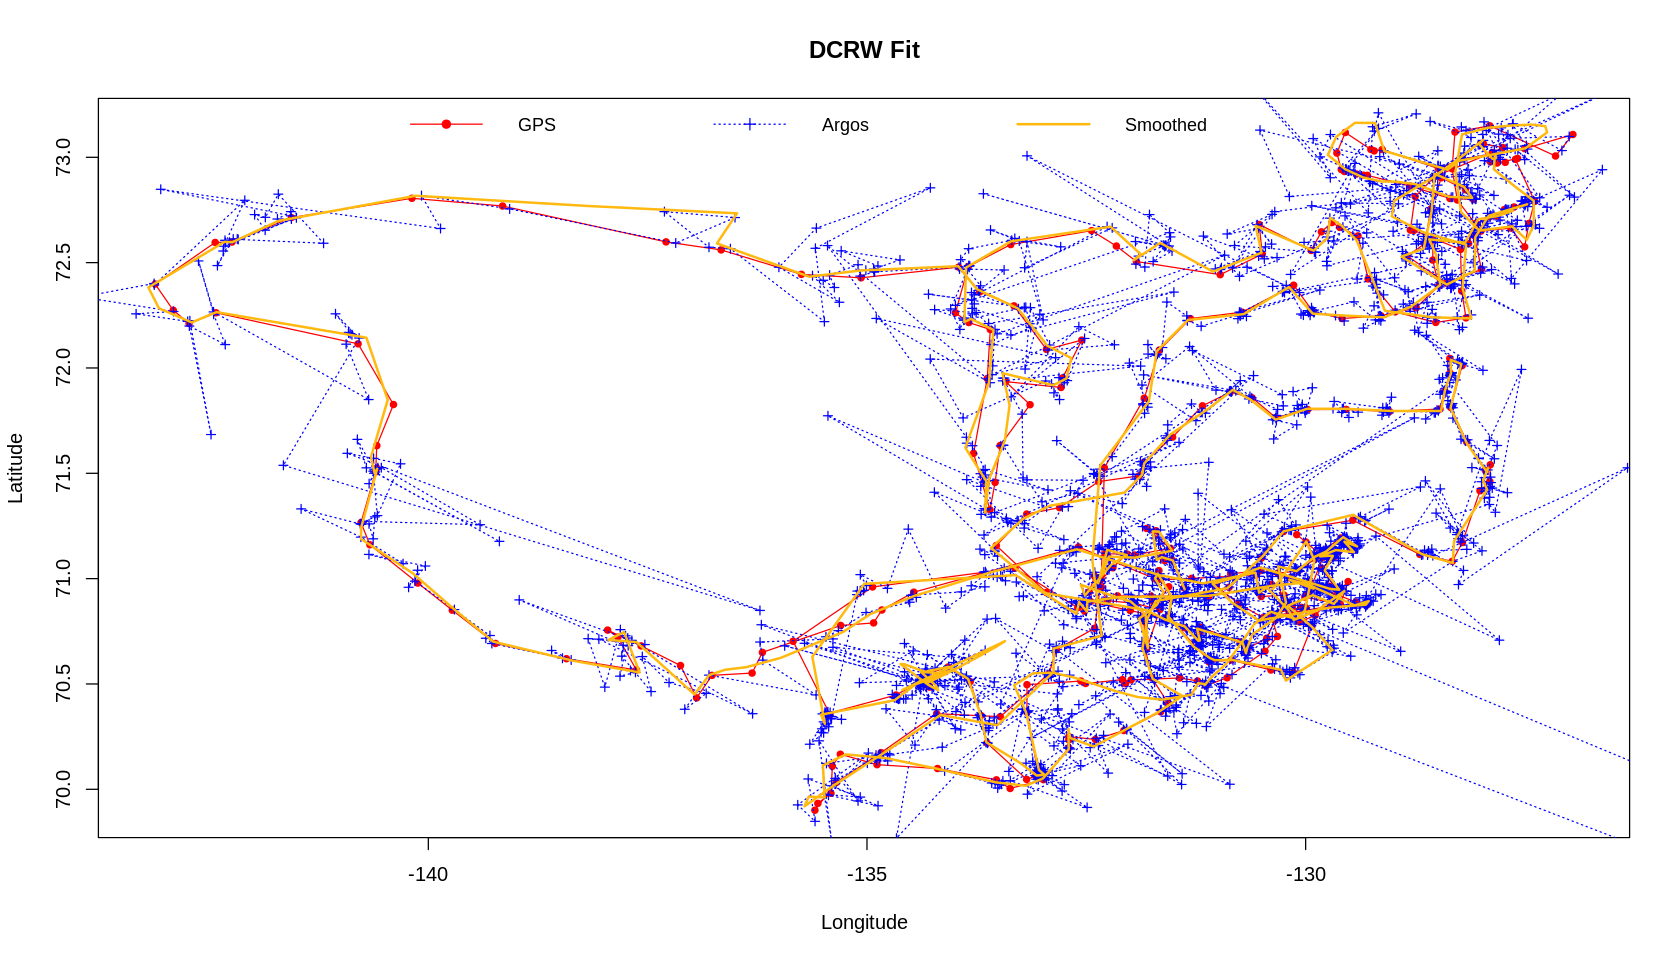

In [ ]:
# Plot Argos (blue), GPS (red), smoothed (goldenrod)
plot(
    data_pb_gps$Lon,
    data_pb_gps$Lat,
    type = "o",
    pch = 19,
    cex = 0.7,
    col = "red",
    xlab = "Longitude",
    ylab = "Latitude",
    main = "DCRW Fit"
)

points(
    data_pb_argos$Lon,
    data_pb_argos$Lat,
    type = "o",
    pch = 3,
    cex = 0.7,
    col = "blue",
    lty = 3
)

lines(
    z_hat[,1],
    z_hat[,2],
    cex = 0.5,
    col = "darkgoldenrod1",
    lwd = 2
)

legend(
    "top",
    legend = c("GPS", "Argos", "Smoothed"),
    pch = c(19, 3, NA),
    col = c("red", "blue", "darkgoldenrod1"),
    lty = c(1, 3, 1),
    lwd = c(1, 1, 2),
    bty = "n",
    cex = 0.9,
    horiz = TRUE
)

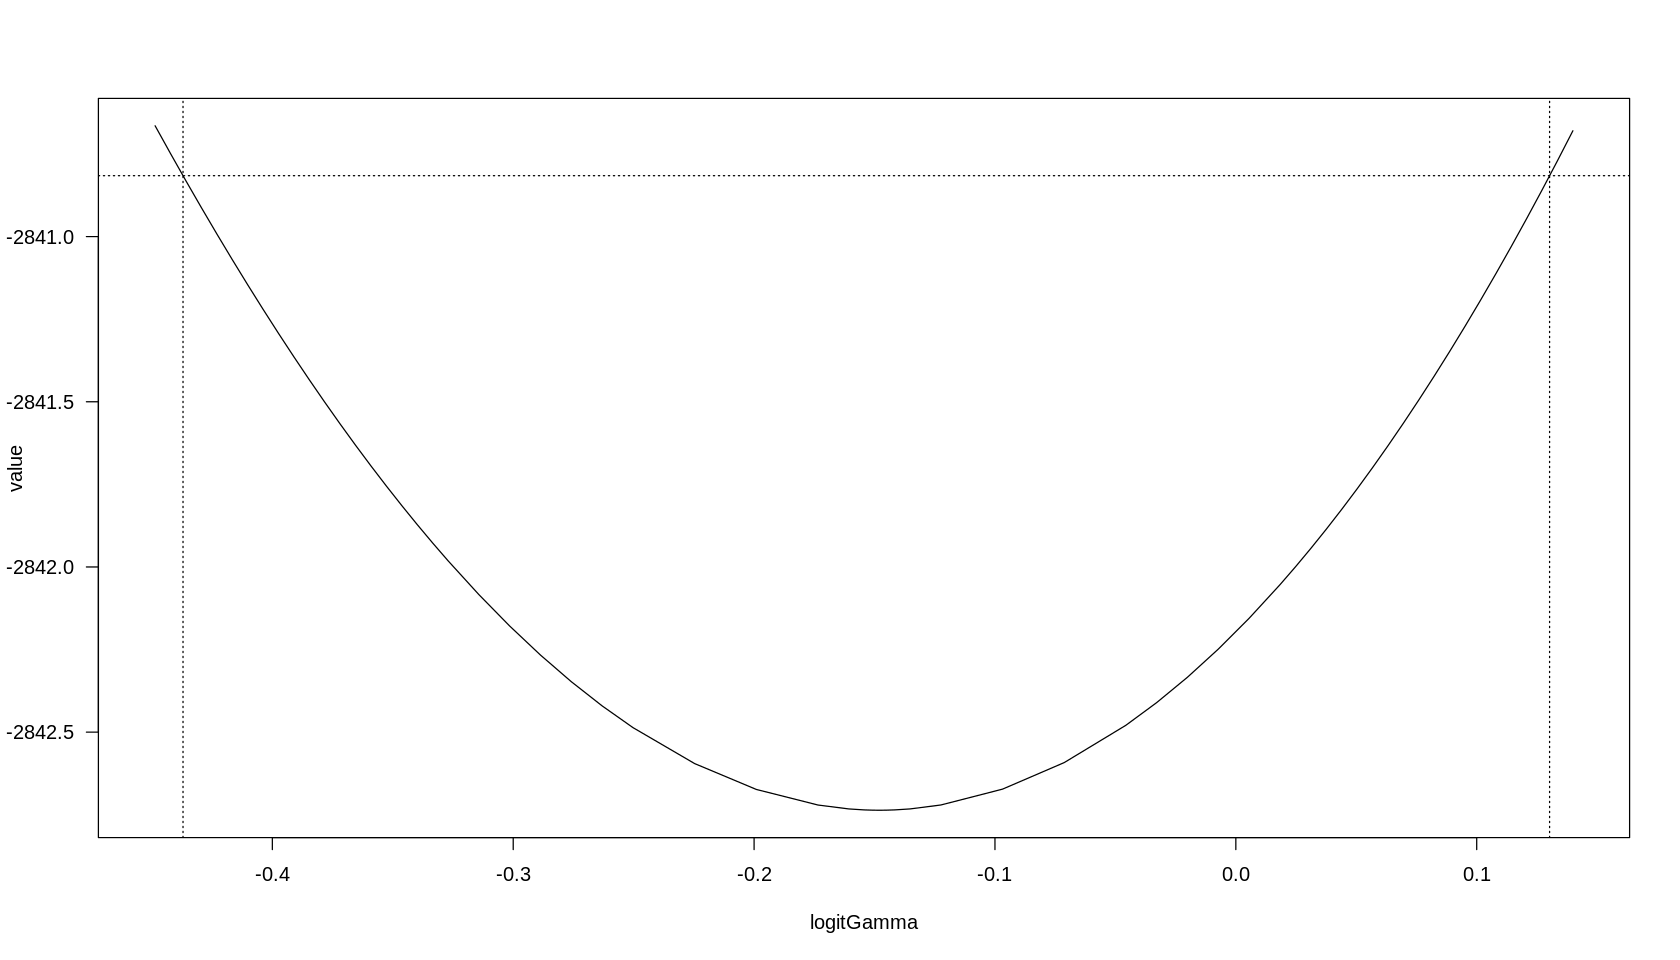

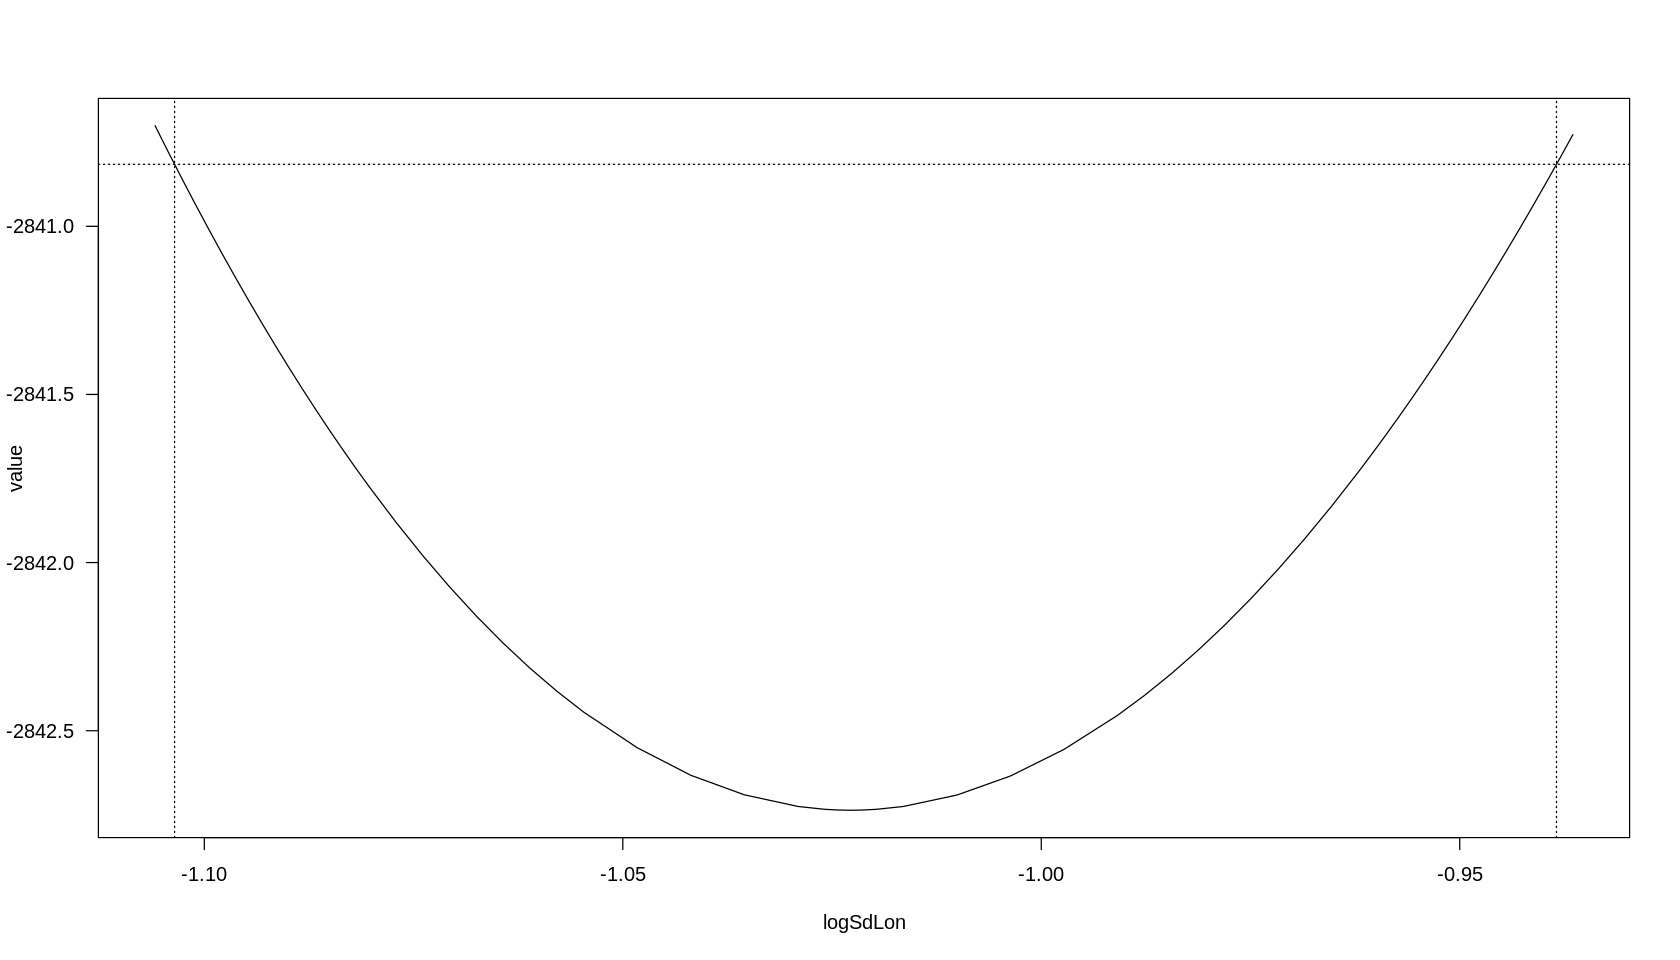

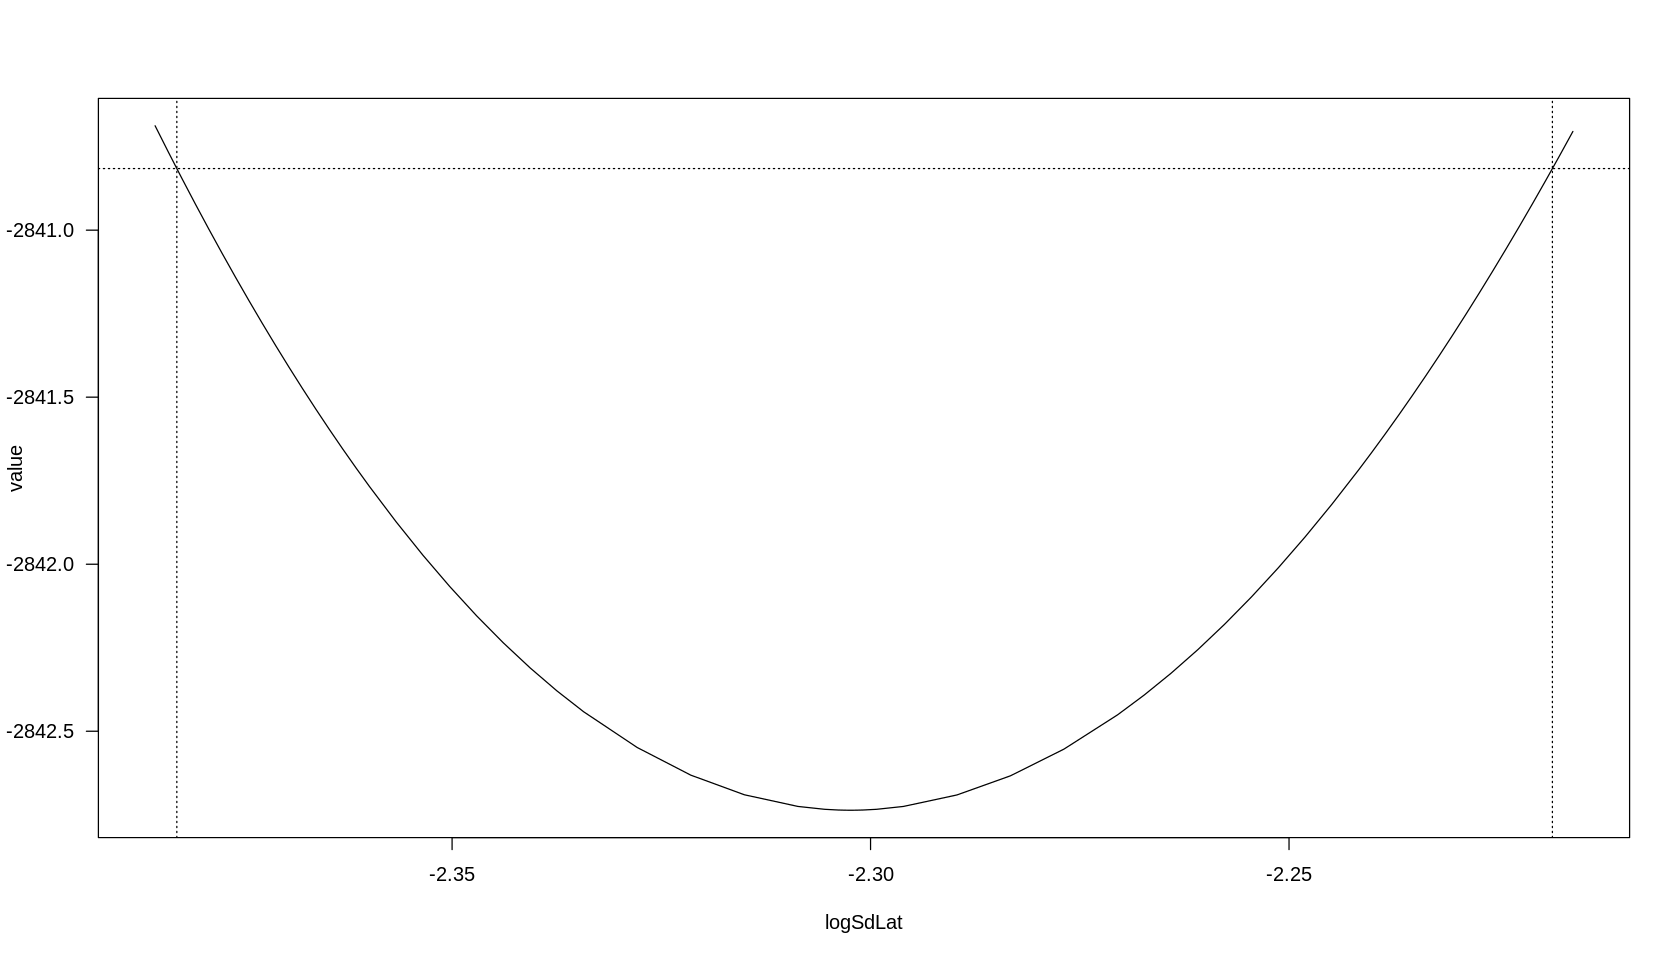

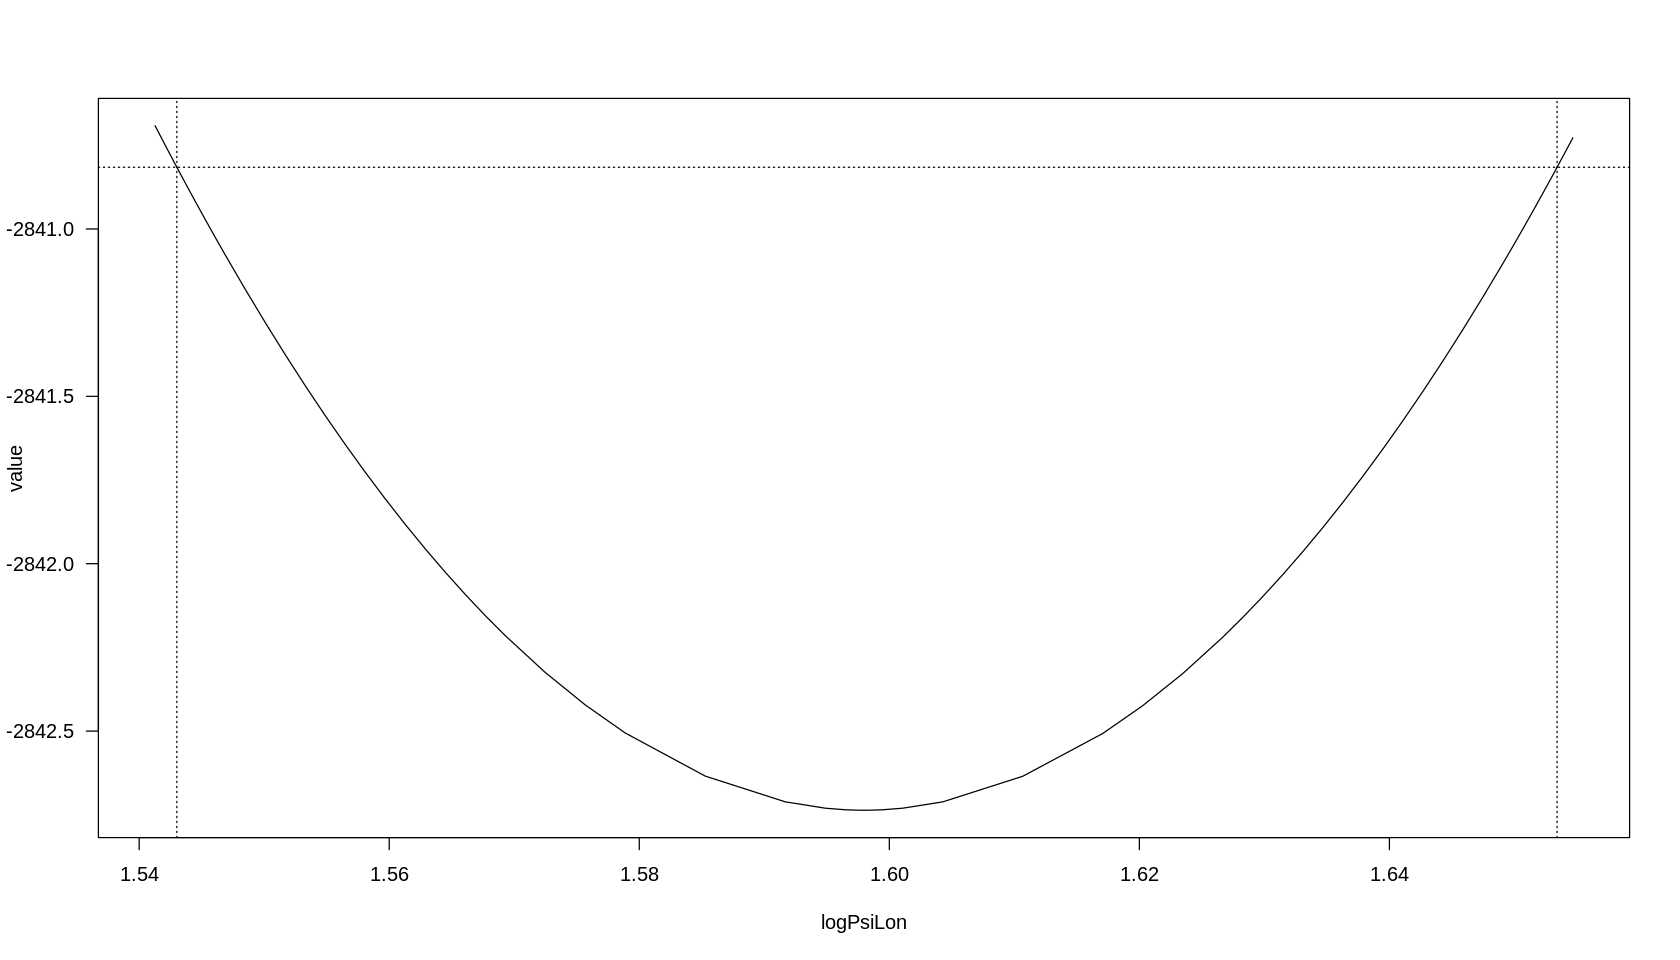

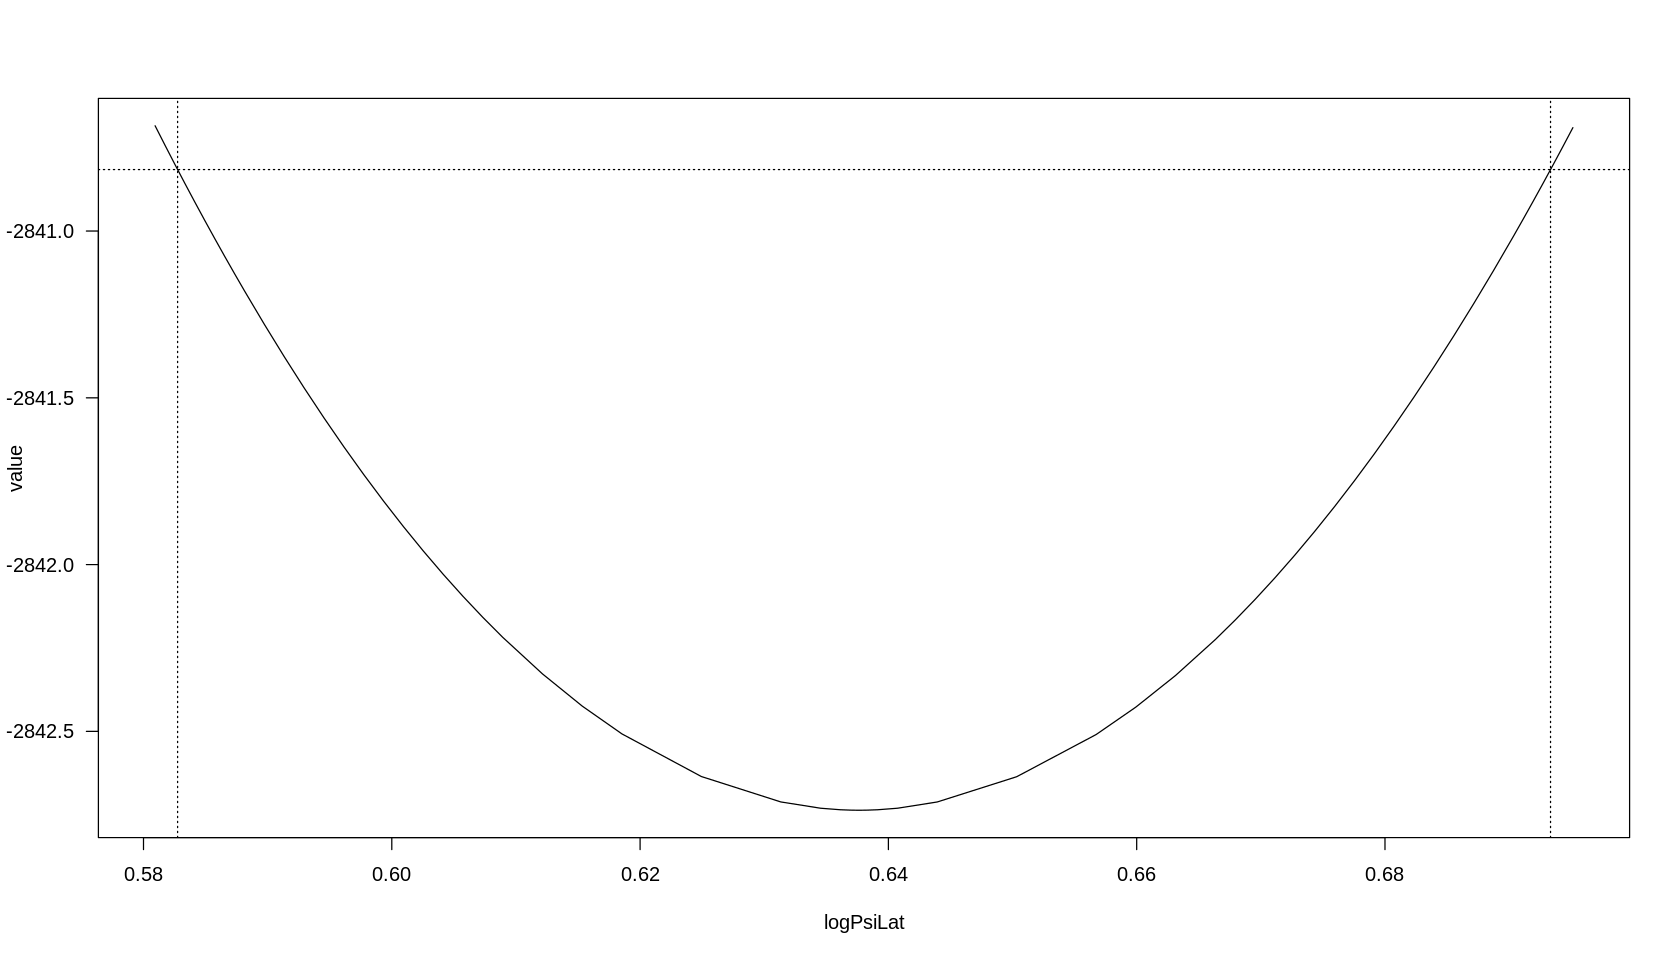

In [ ]:
# Profiling
for(par in c("logitGamma", "logSdLon", "logSdLat", "logPsiLon", "logPsiLat")) {
    pr <- tmbprofile(model_tmb, par, trace = FALSE)
    plot(pr, las = 1)
}

In [ ]:
# Laplace‐approx check
set.seed(123)
consistency_tmb <- checkConsistency(model_tmb, n = 200)
consistency_tmb

Parameters used for simulation:
logitGamma   logSdLon   logSdLat  logPsiLon  logPsiLat 
-0.1479698 -1.0227801 -2.3023833  1.5979752  0.6376354 

Test correct simulation (p.value):
[1] 0.9357855
Simulation appears to be correct

Estimated parameter bias:
  logitGamma     logSdLon     logSdLat    logPsiLon    logPsiLat 
 0.011122176 -0.004724686 -0.003598385  0.005886900  0.006199862 

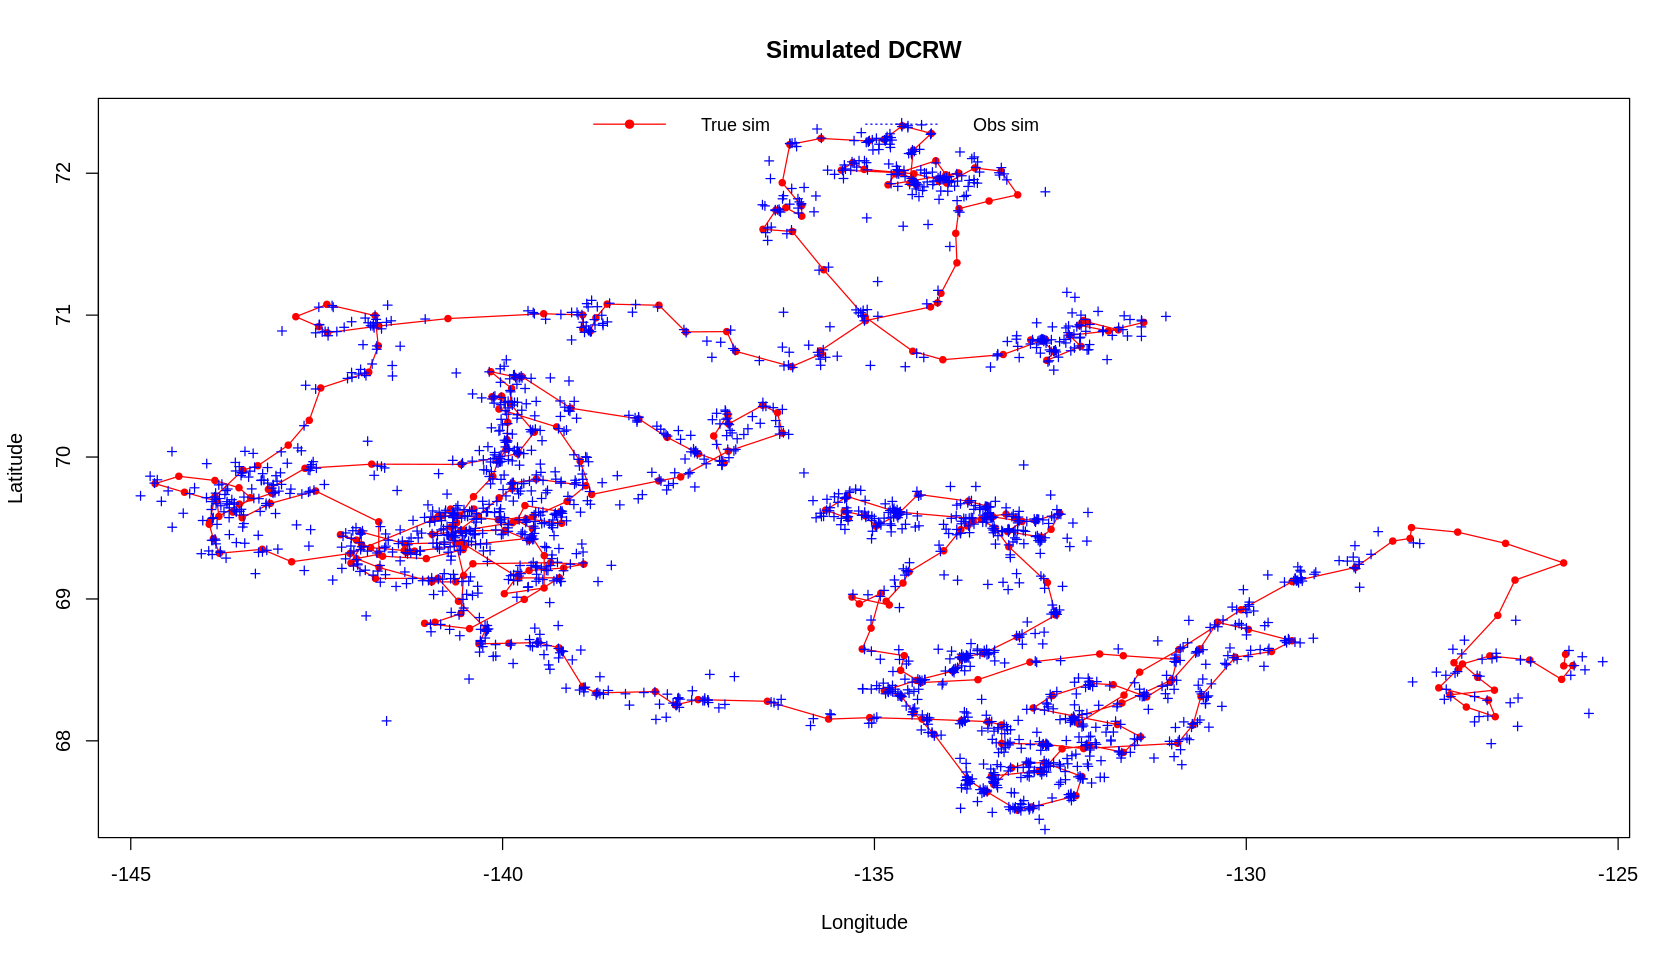

In [ ]:
# Simulate new track
sim <- model_tmb$simulate()
plot(
    sim$z[,1],
    sim$z[,2],
    type = "o",
    pch = 19,
    cex = 0.7,
    col = "red",
    xlab = "Longitude",
    ylab = "Latitude",
    main = "Simulated DCRW"
)

points(
    sim$y[,1],
    sim$y[,2],
    pch = 3,
    cex = 0.7,
    col = "blue",
    lty = 3
)

legend(
    "top",
    legend = c("True sim", "Obs sim"),
    pch = c(19, 3),
    col = c("red", "blue"),
    lty = c(1, 3),
    bty = "n",
    cex = 0.9,
    horiz = TRUE
)

In [ ]:
# Argos data matrix
head(data_pb_tmb$y)

-131.837,70.365
-131.381,70.953
-131.365,70.957
-131.418,70.909
-131.607,71.331
-132.099,71.225


In [ ]:
# Argos data array
head(array(data_pb_tmb$y))

[1] -131.837 -131.381 -131.365 -131.418 -131.607 -132.099

In [ ]:
# Create index vector
pb_keep_idx <- as.vector(t(matrix(1:length(data_pb_tmb$y), ncol = 2)))
head(pb_keep_idx)

[1]    1 1920    2 1921    3 1922

In [ ]:
# One‐step-ahead residuals
pb_res <- oneStepPredict(
    model_tmb,
    observation.name = "y",
    data.term.indicator = "keep",
    discrete = FALSE,
    subset = pb_keep_idx,
    trace = FALSE
)

pb_res_lon <- pb_res[seq(3, nrow(pb_res), by = 2), "residual"]
pb_res_lat <- pb_res[seq(4, nrow(pb_res), by = 2), "residual"]

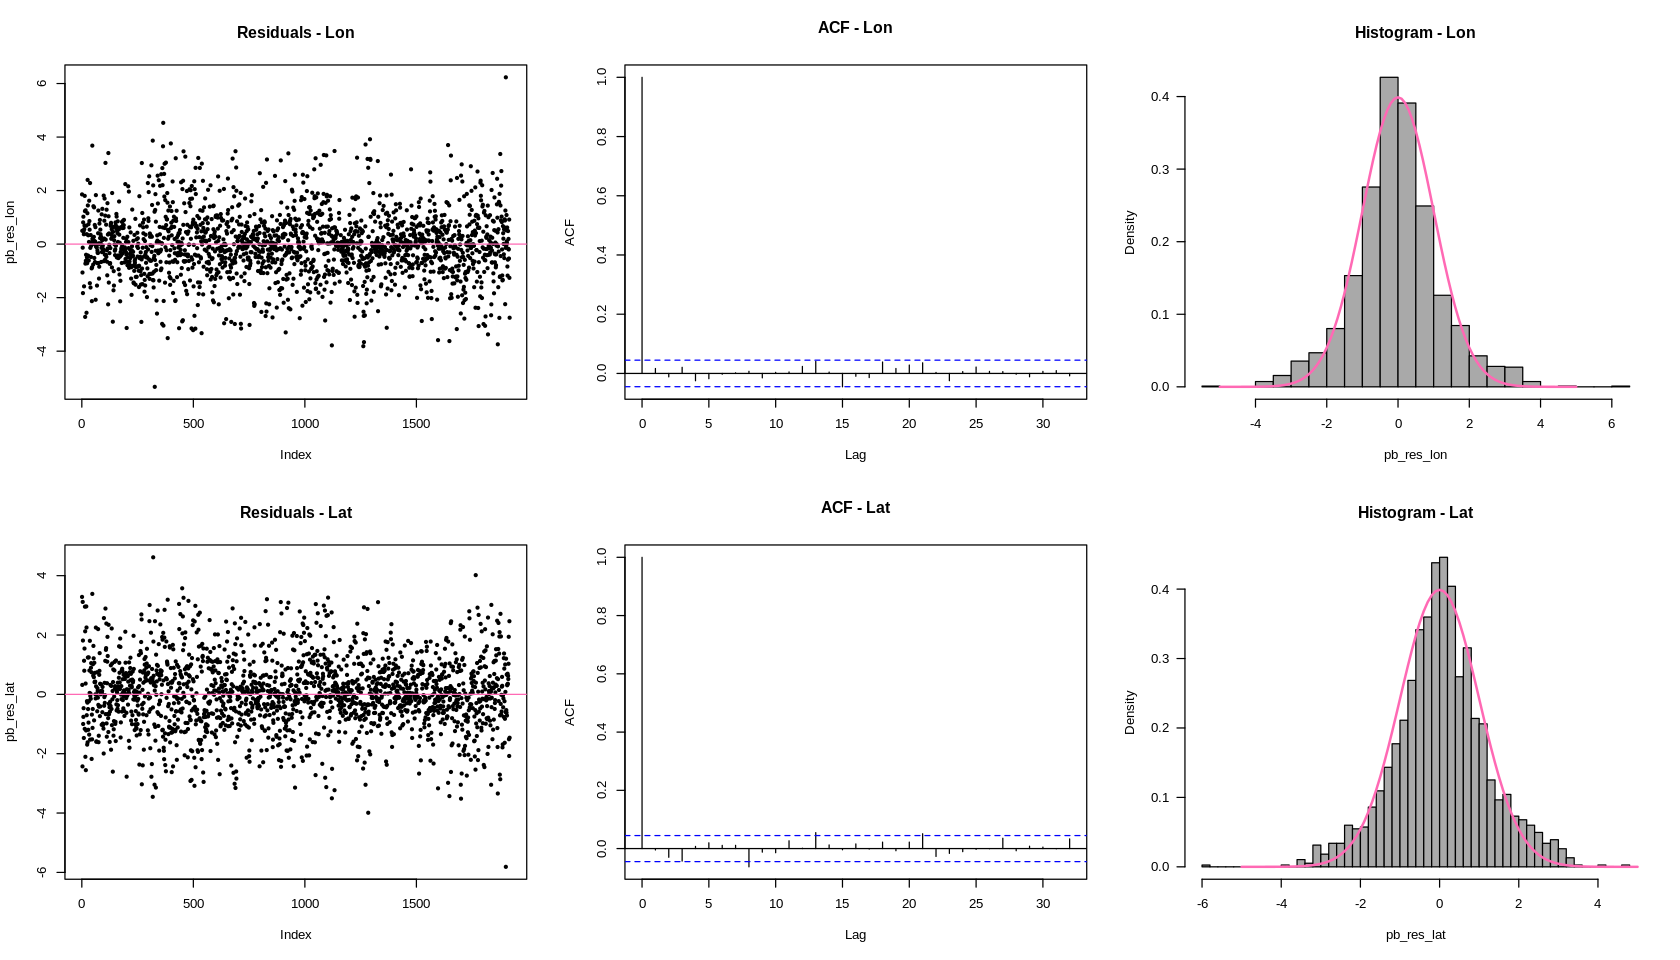

In [ ]:
# Plots
par(mfrow=c(2, 3))
plot(
    pb_res_lon,
    pch = 19,
    cex = 0.5,
    main = "Residuals - Lon"
)
abline(h = 0, col = "hotpink")

acf(pb_res_lon, main = "ACF - Lon")

hist(
    pb_res_lon,
    freq = FALSE,
    breaks = 40,
    col = "darkgrey",
    las = 1,
    main = "Histogram - Lon"
)
curve(
    dnorm,
    -5,
    5,
    add = TRUE,
    col = "hotpink",
    lwd = 2
)

plot(
    pb_res_lat,
    pch = 19,
    cex = 0.5,
    main = "Residuals - Lat"
)
abline(h = 0, col = "hotpink")

acf(pb_res_lat, main = "ACF - Lat")

hist(
    pb_res_lat,
    freq = FALSE,
    breaks = 40,
    col = "darkgrey",
    las = 1,
    main = "Histogram - Lat"
)
curve(
    dnorm,
    -5,
    5,
    add = TRUE,
    col = "hotpink",
    lwd = 2
)

# Stan Model

In [ ]:
# Install rstan package if not already installed
if (!require("rstan")) {
  install.packages("rstan")
}

library(rstan)

Loading required package: rstan

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘rstan’”
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘numDeriv’, ‘abind’, ‘tensorA’, ‘distributional’, ‘checkmate’, ‘matrixStats’, ‘posterior’, ‘StanHeaders’, ‘inline’, ‘gridExtra’, ‘RcppParallel’, ‘loo’, ‘QuickJSR’, ‘BH’


Loading required package: StanHeaders


rstan version 2.32.7 (Stan version 2.32.2)


For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
For within-chain threading using `reduce_sum()` or `map_rect()` Stan functions,
change `threads_per_chain` option:
rstan_options(threads_per_chain = 1)




In [ ]:
# Write the Stan model to file
stan_code <- '
data {
  int<lower=1> TTy;              // Number of Argos observations
  vector[2] y[TTy];              // Observed lon/lat
  int<lower=1> intval[TTy];      // Which latent interval each obs falls into
  vector[TTy] j;                 // Interpolation weight

  int<lower=1> TTz;              // Number of latent states

  vector[2] DD[TTy];             // Degrees of freedom for t-errors (lon, lat)
  vector[2] SS[TTy];             // Scale parameters for t-errors (lon, lat)
}

parameters {
  real<lower=0> sigma_lon;
  real<lower=0> sigma_lat;
  real<lower=0, upper=1> gamma;

  vector[2] z[TTz];

  real<lower=0> psi_lon;
  real<lower=0> psi_lat;
}

model {
  // Priors
  gamma ~ uniform(0, 1);
  sigma_lon ~ student_t(3, 0, 1);
  sigma_lat ~ student_t(3, 0, 1);
  psi_lon ~ student_t(3, 0, 1);
  psi_lat ~ student_t(3, 0, 1);

  // Process model: first step = simple RW
  z[2, 1] ~ normal(z[1, 1], sigma_lon);
  z[2, 2] ~ normal(z[1, 2], sigma_lat);

  // Correlated random walk for t ≥ 3
  for (m in 3:TTz) {
    z[m, 1] ~ normal(z[m-1, 1] + gamma * (z[m-1, 1] - z[m-2, 1]), sigma_lon);
    z[m, 2] ~ normal(z[m-1, 2] + gamma * (z[m-1, 2] - z[m-2, 2]), sigma_lat);
  }

  // Observation model
  for (t in 1:TTy) {
    // Interpolate state to obs time
    vector[2] mu;
    mu[1] = j[t] * z[intval[t]-1, 1]
          + (1-j[t]) * z[intval[t], 1];
    mu[2] = j[t] * z[intval[t]-1, 2]
          + (1-j[t]) * z[intval[t], 2];

    y[t, 1] ~ student_t(DD[t, 1], mu[1], psi_lon * SS[t, 1]);
    y[t, 2] ~ student_t(DD[t, 2], mu[2], psi_lat * SS[t, 2]);
  }
}
'
writeLines(stan_code, con = "dcrw.stan")

In [ ]:
# Run in parallel
options(mc.cores = parallel::detectCores())
rstan_options(auto_write = TRUE)

In [ ]:
# Prepare data list for Stan
data_pb_stan <- list(
    TTy = nrow(data_pb_argos),
    y = cbind(data_pb_argos$Lon, data_pb_argos$Lat),
    intval = data_pb_argos$idx,
    j = data_pb_argos$ji,
    TTz = max(data_pb_argos$idx),
    DD = data_pb_argos$ac[,c("NuLon","NuLat")],
    SS = data_pb_argos$ac[,c("TLon","TLat")]
)

In [ ]:
# Fit
fit_stan <- stan(
    file = "dcrw.stan",
    data = data_pb_stan,
    chains = 3,
    iter = 4000,  # 2000 warmup + 2000 samples
    seed = 123,
    control = list(adapt_delta = 0.95, max_treedepth = 15)
)

# Model Evaluation

In [ ]:
# Diagnostics
rstan::check_hmc_diagnostics(fit_stan)


Divergences:


0 of 6000 iterations ended with a divergence.




Tree depth:


0 of 6000 iterations saturated the maximum tree depth of 15.




Energy:


E-BFMI indicated no pathological behavior.



In [ ]:
# Print the parameters
print(
    fit_stan,
    pars = c(
        "sigma_lon",
        "sigma_lat",
        "gamma",
        "psi_lon",
        "psi_lat"
    )
)

Inference for Stan model: anon_model.
3 chains, each with iter=4000; warmup=2000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=6000.

          mean se_mean   sd 2.5%  25%  50%  75% 97.5% n_eff Rhat
sigma_lon 0.35       0 0.02 0.32 0.34 0.35 0.36  0.38  3322    1
sigma_lat 0.10       0 0.00 0.09 0.10 0.10 0.10  0.11  4752    1
gamma     0.48       0 0.04 0.40 0.45 0.47 0.50  0.55  4488    1
psi_lon   5.64       0 0.16 5.33 5.53 5.64 5.74  5.96  4417    1
psi_lat   2.08       0 0.06 1.97 2.04 2.08 2.12  2.20  5006    1

Samples were drawn using NUTS(diag_e) at Sat Apr 26 10:09:29 2025.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [ ]:
# Print the states
print(fit_stan, pars = c("z"), max = 50)

Inference for Stan model: anon_model.
3 chains, each with iter=4000; warmup=2000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=6000.

            mean se_mean   sd    2.5%     25%     50%     75%   97.5% n_eff
z[1,1]   -131.50    0.00 0.21 -131.87 -131.64 -131.51 -131.37 -131.06  4706
z[1,2]     70.81    0.00 0.09   70.65   70.75   70.81   70.86   70.98  6015
z[2,1]   -131.38    0.00 0.02 -131.43 -131.39 -131.38 -131.36 -131.34  4638
z[2,2]     70.95    0.00 0.01   70.94   70.95   70.95   70.96   70.97  5239
z[3,1]   -131.55    0.00 0.02 -131.59 -131.56 -131.55 -131.53 -131.50  7426
         Rhat
z[1,1]   1.00
z[1,2]   1.00
z[2,1]   1.00
z[2,2]   1.00
z[3,1]   1.00
 [ reached 'max' / getOption("max.print") -- omitted 729 rows ]

Samples were drawn using NUTS(diag_e) at Sat Apr 26 10:09:29 2025.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [ ]:
# Extract latent states
z_samples <- rstan::extract(fit_stan, pars = c("z"))[[1]]

In [ ]:
# Posterior mean and 95% CI for lon
z_lon_mean <- colMeans(z_samples[,,1])
z_lon_CI <- apply(z_samples[,,1], 2, quantile, probs = c(0.025, 0.975))

In [ ]:
# Posterior mean and 95% CI for lat
z_lat_mean <- colMeans(z_samples[,,2])
z_lat_CI <- apply(z_samples[,,2], 2, quantile, probs = c(0.025, 0.975))

In [ ]:
# Match to GPS times
gps_idx <- match(
    as.Date(data_pb_gps$DateTime, format = "%Y.%m.%d %H:%M:%S"),
    as.Date(all_days)
)

In [ ]:
# Compute RMSE
rmse_lon <- sqrt(mean((data_pb_gps$Lon - z_lon_mean[gps_idx + 1])^2))
rmse_lat <- sqrt(mean((data_pb_gps$Lat - z_lat_mean[gps_idx + 1])^2))

In [ ]:
# Print RMSE
cbind(RMSE_lon = rmse_lon, RMSE_lat = rmse_lat)

RMSE_lon,RMSE_lat
0.1447455,0.03810262


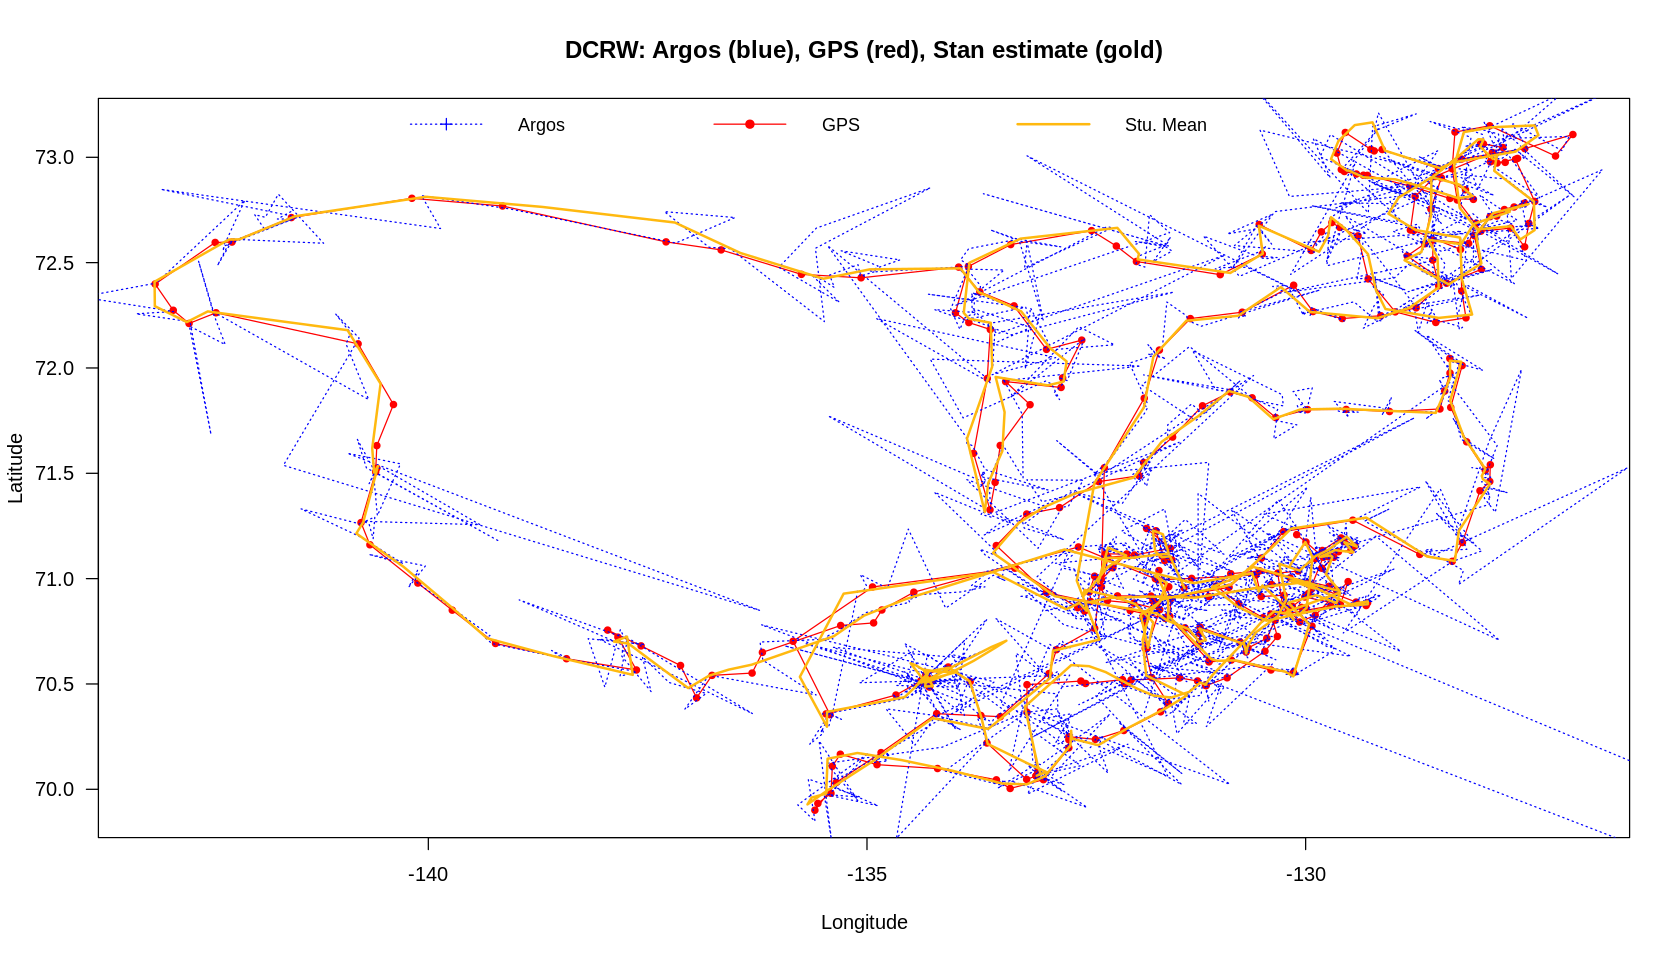

In [ ]:
# Plot estimated track vs. Argos and GPS
plot(
    data_pb_gps$Lon,
    data_pb_gps$Lat,
    type = "o",
    pch = 19,
    cex = 0.7,
    col = "red",
    xlab = "Longitude",
    ylab = "Latitude",
    las = 1,
    main = "DCRW: Argos (blue), GPS (red), Stan estimate (gold)"
)

points(
    data_pb_argos$Lon,
    data_pb_argos$Lat,
    type = "l",
    pch = 3,
    cex = 0.7,
    col = "blue",
    lty = 3
)

lines(
    z_lon_mean[gps_idx + 1],
    z_lat_mean[gps_idx + 1],
    lwd = 2,
    cex = 0.5,
    col = "darkgoldenrod1"
)

legend(
    "top",
    legend = c("Argos", "GPS", "Stu. Mean"),
    col = c("blue", "red", "darkgoldenrod1"),
    lty = c(3, 1, 1),
    pch = c(3, 19, NA),
    lwd = c(1, 1, 2),
    bty = "n",
    cex = 0.9,
    horiz = TRUE
)